# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress
from pprint import pprint
from datetime import datetime

# Import API key
from config import weather_api_key

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "output_data/cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

## Generate Cities List

In [2]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(lat_range[0], lat_range[1], size=1500)
lngs = np.random.uniform(lng_range[0], lng_range[1], size=1500)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

# Print the city count to confirm sufficient count
print(len(cities))


631


### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [3]:
# Save config information.
url = "http://api.openweathermap.org/data/2.5/weather?"
units = "imperial"

# Build partial query URL
query_url = f"{url}appid={weather_api_key}&units={units}&q="


In [37]:
#Build summary dataframe
cityDF= pd.DataFrame({"City": cities,
                      "Lat": "",
                      "Lng":"",
                      "Max Temp":"",
                      "Humidity":"",
                      "Cloudiness":"",
                      "Wind Speed":"",
                      "Country":"",
                      "Date":""
                                
                               })

#uncomment this for testing smaller dataset
cityDF = cityDF.iloc[0:50] 

# Loop through the cityDF and find all weather data for each city
print("Beginning Data Retrieval")     
print("-----------------------------")

for index, row in cityDF.iterrows():
    try:
        city = row['City']
        response = requests.get(query_url + city).json()
        cityDF.loc[index,"Lat"] = response["coord"]['lat']
        cityDF.loc[index,"Lng"] = response["coord"]['lon']
        cityDF.loc[index,"Max Temp"] = response["main"]['temp_max']
        cityDF.loc[index,"Humidity"] = response["main"]['humidity']
        cityDF.loc[index,"Cloudiness"] = response["clouds"]['all']
        cityDF.loc[index,"Wind Speed"] = response["wind"]['speed']
        cityDF.loc[index,"Country"] = response["sys"]['country']
        cityDF.loc[index,"Date"] = response["dt"]
        print("Processing Record "+str(index+1)+" of Set 1 | "+city)
        
    except KeyError:
        print("City not found..Skipping...|"+city)
    except:
        print("ERROR..Skipping...|"+city)

Beginning Data Retrieval
-----------------------------
Processing Record 1 of Set 1 | tura
City not found..Skipping...|sentyabrskiy
City not found..Skipping...|taolanaro
Processing Record 4 of Set 1 | nome
Processing Record 5 of Set 1 | tampa
Processing Record 6 of Set 1 | bredasdorp
Processing Record 7 of Set 1 | nazca
Processing Record 8 of Set 1 | gat
Processing Record 9 of Set 1 | iquitos
Processing Record 10 of Set 1 | dikson
Processing Record 11 of Set 1 | atuona
Processing Record 12 of Set 1 | jimma
Processing Record 13 of Set 1 | woodward
Processing Record 14 of Set 1 | aksu
Processing Record 15 of Set 1 | upernavik
Processing Record 16 of Set 1 | busselton
Processing Record 17 of Set 1 | comodoro rivadavia
Processing Record 18 of Set 1 | anadyr
Processing Record 19 of Set 1 | saint-philippe
Processing Record 20 of Set 1 | victoria
Processing Record 21 of Set 1 | rikitea
Processing Record 22 of Set 1 | mataura
Processing Record 23 of Set 1 | hasaki
Processing Record 24 of Set 1

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [38]:
cityDF.to_csv(output_data_file,index=False)
cityDF.head(100)

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,tura,25.5198,90.2201,81.84,28,0,5.95,IN,1613285798
1,sentyabrskiy,,,,,,,,
2,taolanaro,,,,,,,,
3,nome,64.5011,-165.406,17.6,62,1,10.36,US,1613285799
4,tampa,27.9475,-82.4584,71.01,83,90,6.91,US,1613285591
5,bredasdorp,-34.5322,20.0403,71.6,64,3,5.75,ZA,1613285799
6,nazca,-14.8333,-74.95,67.41,68,28,0.29,PE,1613285799
7,gat,31.61,34.7642,60.01,36,0,0.56,IL,1613285799
8,iquitos,-3.7481,-73.2472,77,94,75,1.14,PE,1613285799
9,dikson,73.5069,80.5464,-16.13,89,100,12.17,RU,1613285799


In [39]:

ts = int("1613283332")
#print(ts)
#print(datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d'))


print(datetime.utcfromtimestamp(cityDF.loc[index,"Date"]).strftime('%m/%d/%Y'))

02/14/2021


## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

In [40]:
HumidityOutliers = []

for index, row in cityDF.iterrows():
    if cityDF.loc[index,"Humidity"] != "":
        if cityDF.loc[index,"Humidity"] > 100:
            HumidityOutliers.append(index)


In [41]:
#  Get the indices of cities that have humidity over 100%.
print("Indices with humidity over 100%")
print(HumidityOutliers )

Indices with humidity over 100%
[]


In [42]:
# Make a new DataFrame equal to the city data to drop all humidity outliers by index.
# Passing "inplace=False" will make a copy of the city_data DataFrame, which we call "clean_city_data".
clean_city_data = cityDF.drop(HumidityOutliers, inplace=False)

#also drop cities where no data was found
clean_city_data = clean_city_data[clean_city_data['Lat'] != ""]

#reset index
clean_city_data = clean_city_data.reset_index()
#Display dataframe

clean_city_data.head(10)

,index,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,0,tura,25.5198,90.2201,81.84,28,0,5.95,IN,1613285798
1,3,nome,64.5011,-165.406,17.6,62,1,10.36,US,1613285799
2,4,tampa,27.9475,-82.4584,71.01,83,90,6.91,US,1613285591
3,5,bredasdorp,-34.5322,20.0403,71.6,64,3,5.75,ZA,1613285799
4,6,nazca,-14.8333,-74.95,67.41,68,28,0.29,PE,1613285799
5,7,gat,31.61,34.7642,60.01,36,0,0.56,IL,1613285799
6,8,iquitos,-3.7481,-73.2472,77,94,75,1.14,PE,1613285799
7,9,dikson,73.5069,80.5464,-16.13,89,100,12.17,RU,1613285799
8,10,atuona,-9.8,-139.033,78.62,80,8,17.18,PF,1613285799
9,11,jimma,7.6667,36.8333,81.61,31,1,2.28,ET,1613285800


## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

## Latitude vs. Temperature Plot

<function matplotlib.pyplot.show(close=None, block=None)>

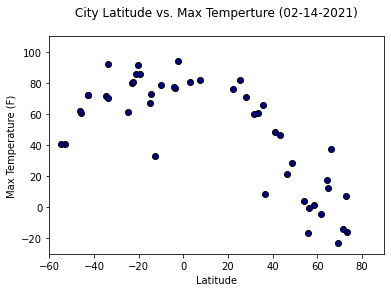

In [46]:
x_values = clean_city_data['Lat']
y_values = clean_city_data['Max Temp']
DT = datetime.utcfromtimestamp(clean_city_data.loc[0,"Date"]).strftime('%m-%d-%Y')

plt.ylim(-30,110)
plt.xlim(-60,90)
plt.xlabel("Latitude")
plt.ylabel("Max Temperature (F)")
plt.title("City Latitude vs. Max Temperture ("+str(DT)+")",pad=20)
plt.scatter(x_values, y_values, marker="o", facecolors="navy",edgecolors="black")

plt.savefig("LatitudevsTemperature")
plt.show


## Latitude vs. Humidity Plot

<function matplotlib.pyplot.show(close=None, block=None)>

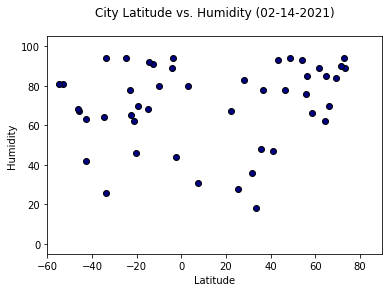

In [48]:
x_values = clean_city_data['Lat']
y_values = clean_city_data['Humidity']
DT = datetime.utcfromtimestamp(clean_city_data.loc[0,"Date"]).strftime('%m-%d-%Y')

plt.ylim(-5,105)
plt.xlim(-60,90)
plt.xlabel("Latitude")
plt.ylabel("Humidity")
plt.title("City Latitude vs. Humidity ("+str(DT)+")",pad=20)
plt.scatter(x_values, y_values, marker="o", facecolors="navy",edgecolors="black")

plt.savefig("LatitudevsHumidity")
plt.show

## Latitude vs. Cloudiness Plot

<function matplotlib.pyplot.show(close=None, block=None)>

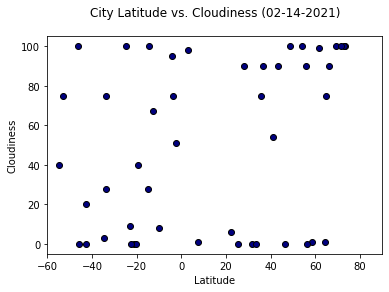

In [49]:
x_values = clean_city_data['Lat']
y_values = clean_city_data['Cloudiness']
DT = datetime.utcfromtimestamp(clean_city_data.loc[0,"Date"]).strftime('%m-%d-%Y')

plt.ylim(-5,105)
plt.xlim(-60,90)
plt.xlabel("Latitude")
plt.ylabel("Cloudiness")
plt.title("City Latitude vs. Cloudiness ("+str(DT)+")",pad=20)
plt.scatter(x_values, y_values, marker="o", facecolors="navy",edgecolors="black")

plt.savefig("LatitudevsCloudiness")
plt.show

## Latitude vs. Wind Speed Plot

<function matplotlib.pyplot.show(close=None, block=None)>

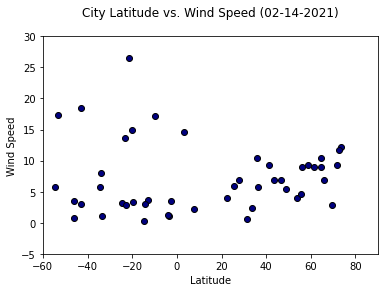

In [52]:
x_values = clean_city_data['Lat']
y_values = clean_city_data['Wind Speed']
DT = datetime.utcfromtimestamp(clean_city_data.loc[0,"Date"]).strftime('%m-%d-%Y')

plt.ylim(-5,30)
plt.xlim(-60,90)
plt.xlabel("Latitude")
plt.ylabel("Wind Speed")
plt.title("City Latitude vs. Wind Speed ("+str(DT)+")",pad=20)
plt.scatter(x_values, y_values, marker="o", facecolors="navy",edgecolors="black")

plt.savefig("LatitudevsWind Speed")
plt.show

## Linear Regression

####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression